Welcome to the Prognostic Analyses based on LASSO-COX Joined Model, providing a gene signature to calculate the risk score in gastric cancer patients using their transcriptomic data. 

In [479]:
import pandas as pd
import numpy as np
import sksurv
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from lifelines import CoxPHFitter
from sklearn.preprocessing import LabelEncoder
from lifelines.utils import concordance_index
from sklearn import datasets, linear_model
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
#from sklearn.metrics import cumulative_dynamic_auc
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.datasets import load_flchain, load_gbsg2
from sklearn.model_selection import train_test_split
from lifelines.statistics import logrank_test
from scipy import stats
import random




In [480]:
mrna_tpm = pd.read_csv("STAD_100_mrna_tpm_coding.csv")
Down_DEGs = pd.read_csv("Downreg_DEGs.csv")
Up_DEGs = pd.read_csv("Upreg_DEGs.csv")
clinical_data = pd.read_csv("stad_tcga_clinical_data.tsv", delimiter = '\t')

In [481]:
#filtering the clinical data to contain only stage I and stage III patients found in the mrna_tpm
clinical_data['Sample ID'] = clinical_data['Sample ID'] + 'A'

filtered_clinical_data= clinical_data[clinical_data['Sample ID'].isin(mrna_tpm.columns)]
filtered_clinical_data= filtered_clinical_data[~filtered_clinical_data['Overall Survival (Months)'].isna()] # remove patients with no overall survival data


In [482]:
#remove the patients with no OS from the rna_expression data
mrna_tpm_filtered = mrna_tpm.iloc[:,mrna_tpm.columns.isin(filtered_clinical_data['Sample ID'])]

#Subset the DEGs from mrna_tpm matrix
DEGs_Combined= pd.concat([Down_DEGs["Genes"],Up_DEGs["Genes"]],axis=0)
mrna_tpm_DEGs = mrna_tpm_filtered.iloc[mrna_tpm_filtered.index.isin(DEGs_Combined),:]
#mrna_tpm_DEGs = mrna_tpm_filtered
#print(mrna_tpm_DEGs)
print(mrna_tpm_DEGs)

         TCGA-3M-AB46-01A  TCGA-BR-A4QL-01A  TCGA-BR-A4QM-01A  \
HSPB6              3.0685            3.6839            6.8591   
ASB4               0.0726            0.0604            0.0051   
CACNA1G            0.0181            0.0161            0.0399   
CD79B              0.2801            0.1124            2.7129   
BTK                0.6114            0.4003            1.9966   
...                   ...               ...               ...   
HCAR3              0.0444            0.0225            0.0000   
LYPD8              0.0523            1.3165            0.5891   
MSMB               0.6567            0.1252            0.0510   
PKD1L3             0.0351            0.0223            0.0363   
SYT15B             0.0321            0.0245            0.0178   

         TCGA-CG-5725-01A  TCGA-D7-5577-01A  TCGA-D7-6817-01A  \
HSPB6             15.4979            4.7647            7.5822   
ASB4               0.1502            0.0425            2.5895   
CACNA1G            0.079

In [483]:
# Prepare the data needed for the machine learning models needed on X (Features - RNA expression) and Y (Survival Data)

#Transpose the dataframe
mrna_tpm_DEGs= mrna_tpm_DEGs.T


In [484]:

#Prepare the survival data
survival_data = filtered_clinical_data.iloc[:, [2, 52, 53]]
survival_data.columns = ["Sample ID","Time","Event"]

#Remove the string
survival_data['Event'] = survival_data['Event'].str.split(':').str[0]
#Encode the survival data
le = LabelEncoder()
le.fit(survival_data['Event'])
survival_data['Event'] = le.transform(survival_data['Event'])
survival_data.index=survival_data.iloc[:,0]
survival_data=survival_data.iloc[:,1::]
survival_data['Event']=survival_data['Event'].astype(bool)
survival_data = survival_data.reindex(columns=['Event', 'Time'])



C:\Users\raden\AppData\Local\Temp\ipykernel_19252\367217584.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data['Event'] = survival_data['Event'].str.split(':').str[0]
C:\Users\raden\AppData\Local\Temp\ipykernel_19252\367217584.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data['Event'] = le.transform(survival_data['Event'])


In [485]:
Y=survival_data.to_records(index=False)
X= mrna_tpm_DEGs
scaler = StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X))
X.columns = mrna_tpm_DEGs.columns


In [486]:
random.seed(1)

#Testing the range of alphas and their corresponding number of genes selected
estimator=CoxnetSurvivalAnalysis(n_alphas=10, l1_ratio=1, alpha_min_ratio=0.01 ,verbose = 10)
estimator.fit(X,Y)

#Making the dataframe for the coefficients of each genes corresponding to that alpha value
coefficients_lasso=pd.DataFrame(estimator.coef_, index=X.columns, columns=np.round(estimator.alphas_, 3))
alphas_estimated=estimator.alphas_
alphas=estimator.alphas_

for i, col in enumerate(coefficients_lasso.columns):
    non_zero = np.sum(coefficients_lasso[col] != 0)  # Count non-zeros in each column
    print(f"Column {i+1}: Number of non-zero coefficients: {non_zero}")

Column 1: Number of non-zero coefficients: 0
Column 2: Number of non-zero coefficients: 12
Column 3: Number of non-zero coefficients: 24
Column 4: Number of non-zero coefficients: 40
Column 5: Number of non-zero coefficients: 50
Column 6: Number of non-zero coefficients: 62
Column 7: Number of non-zero coefficients: 65
Column 8: Number of non-zero coefficients: 70
Column 9: Number of non-zero coefficients: 76
Column 10: Number of non-zero coefficients: 76


Next, we will check the behavior of each gene coefficient (B-value) with the increase of penalty (alpha)

274 Index([0.183, 0.11, 0.066, 0.04, 0.024, 0.014, 0.009, 0.005, 0.003, 0.002], dtype='float64')


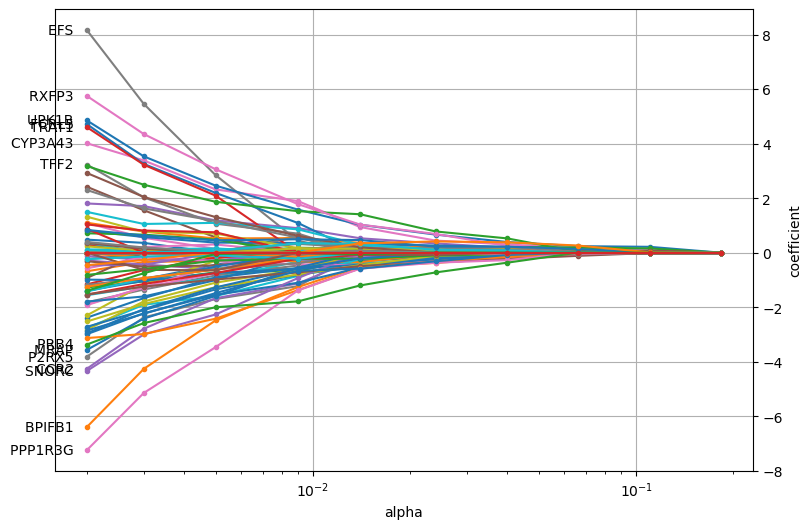

In [487]:
def plot_coefficients(coefs, n_highlight):
    _, ax=plt.subplots(figsize=(9,6))
    n_features=coefs.shape[0]
    alphas=coefs.columns
    print(n_features, alphas)
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min=alphas.min()
    top_coefs=coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef=coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    
#Sending parameters to the function to plot the alpha vs coefficient graph for all the genes, with the 10 mostly divergent genes as hightlights
plot_coefficients(coefficients_lasso, n_highlight=14)
alphas=coefficients_lasso.columns

Based on the previous, we will perform a gridsearch for different values of alphas, while keeping the l1 as 1 (restricted to the lasso penalty)

In [488]:
random.seed(1) 

cv = KFold(n_splits=5, shuffle=True, random_state=1)
gcv = GridSearchCV((CoxnetSurvivalAnalysis(alpha_min_ratio=1, l1_ratio=1)),
    param_grid={"alphas": [[v] for v in alphas]},
    cv=cv, 
    error_score=0.5,
    n_jobs=-1, #to work on the GPU
).fit(X, Y)
cv_results = pd.DataFrame(gcv.cv_results_)

# Display the relevant information
print("Best Parameters:", gcv.best_params_)
print("Best Score:", gcv.best_score_)
print("Grid Search Results:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']])


Best Parameters: {'alphas': [0.04]}
Best Score: 0.6480688995875836
Grid Search Results:
                params  mean_test_score  std_test_score
0  {'alphas': [0.183]}         0.585964        0.058446
1   {'alphas': [0.11]}         0.563604        0.083884
2  {'alphas': [0.066]}         0.558780        0.086621
3   {'alphas': [0.04]}         0.648069        0.099403
4  {'alphas': [0.024]}         0.602727        0.115283
5  {'alphas': [0.014]}         0.544717        0.106957
6  {'alphas': [0.009]}         0.535795        0.044553
7  {'alphas': [0.005]}         0.492438        0.139129
8  {'alphas': [0.003]}         0.422623        0.121019
9  {'alphas': [0.002]}         0.430290        0.083844


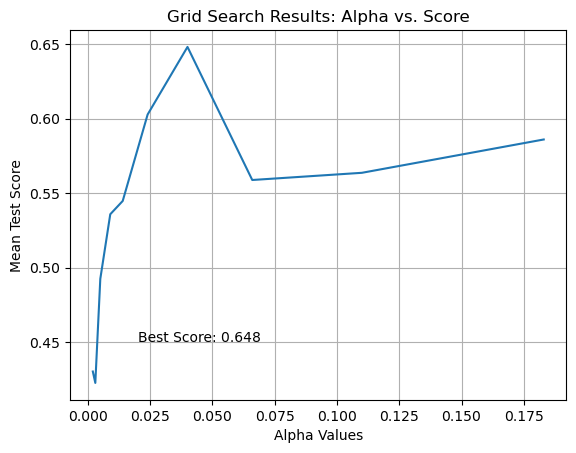

In [504]:
alphas = cv_results["param_alphas"].apply(lambda x: x[0])  # Extract alpha values
scores = cv_results["mean_test_score"]  # Extract mean test scores


plt.plot(alphas, scores)

# Customize plot elements
plt.xlabel("Alpha Values")
plt.ylabel("Mean Test Score")
plt.title("Grid Search Results: Alpha vs. Score")
plt.grid(True)  # Add grid lines

# Optional: Annotate the best score
best_alpha = alphas[scores.argmax()]  # Find the alpha with the best score
best_score = scores.max()
plt.annotate(f"Best Score: {best_score:.3f}", xy=(best_alpha, best_score), xytext=(0.02, 0.45))

plt.show()

The results showed that sticking to lasso penalty showed a c-index of 0.61, which is not an optimum choice; therefore, l1/l2 regularization was iterated 

In [505]:
random.seed(1)

l1_ratios = np.arange(1, -1, -0.05)
cv = KFold(n_splits=5, shuffle=True, random_state=1)
gcv = GridSearchCV((CoxnetSurvivalAnalysis(alpha_min_ratio=1)),
    param_grid={"alphas": [[v] for v in alphas], "l1_ratio" : l1_ratios},
    cv=cv, 
    error_score=0.5,
    n_jobs=-1, #to work on the GPU
).fit(X, Y)
cv_results = pd.DataFrame(gcv.cv_results_)

# Display the relevant information
print("Best Parameters:", gcv.best_params_)
print("Best Score:", gcv.best_score_)
print("Grid Search Results:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']])



Best Parameters: {'alphas': [0.066], 'l1_ratio': 0.3499999999999994}
Best Score: 0.6958610797272567
Grid Search Results:
                                                params  mean_test_score  \
0                 {'alphas': [0.183], 'l1_ratio': 1.0}         0.585964   
1                {'alphas': [0.183], 'l1_ratio': 0.95}         0.573060   
2    {'alphas': [0.183], 'l1_ratio': 0.899999999999...         0.576567   
3    {'alphas': [0.183], 'l1_ratio': 0.849999999999...         0.564200   
4    {'alphas': [0.183], 'l1_ratio': 0.799999999999...         0.584719   
..                                                 ...              ...   
395  {'alphas': [0.002], 'l1_ratio': -0.75000000000...         0.500000   
396  {'alphas': [0.002], 'l1_ratio': -0.80000000000...         0.500000   
397  {'alphas': [0.002], 'l1_ratio': -0.85000000000...         0.500000   
398  {'alphas': [0.002], 'l1_ratio': -0.90000000000...         0.500000   
399  {'alphas': [0.002], 'l1_ratio': -0.95000000000...

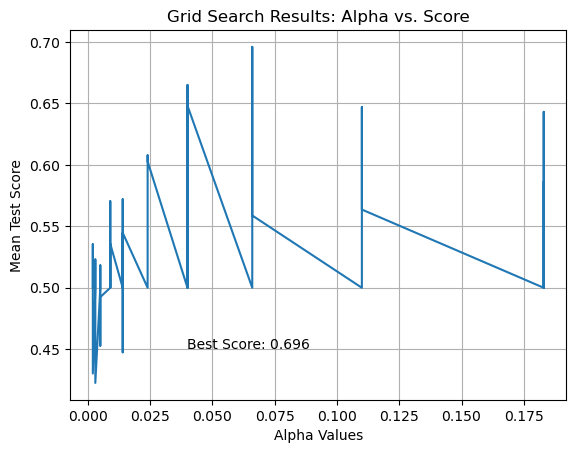

In [507]:
alphas = cv_results["param_alphas"].apply(lambda x: x[0])  # Extract alpha values
scores = cv_results["mean_test_score"]  # Extract mean test scores


plt.plot(alphas, scores)

# Customize plot elements
plt.xlabel("Alpha Values")
plt.ylabel("Mean Test Score")
plt.title("Grid Search Results: Alpha vs. Score")
plt.grid(True)  # Add grid lines

# Optional: Annotate the best score
best_alpha = alphas[scores.argmax()]  # Find the alpha with the best score
best_score = scores.max()
plt.annotate(f"Best Score: {best_score:.3f}", xy=(best_alpha, best_score), xytext=(0.04, 0.45))

plt.show()

Afterwards, the parameters (alphas=~0.066, and l1_ratio=~0.35) showed the best parameters 0.695

In [ ]:
# this chunk can be changed (you can skip it and run the one afterwards for elastic net best parameters)

estimator=CoxnetSurvivalAnalysis( alphas=[0.0395], l1_ratio=1,verbose = 10)
estimator.fit(X,Y)
#Making the dataframe for the coefficients of each genes corresponding to that alpha value
coefficients_lasso=pd.DataFrame(estimator.coef_, index=X.columns, columns=np.round(estimator.alphas_, 5))
alphas=estimator.alphas_

for i, col in enumerate(coefficients_lasso.columns):
    non_zero = np.sum(coefficients_lasso[col] != 0)  # Count non-zeros in each column
    print(f"Column {i+1}: Number of non-zero coefficients: {non_zero}")

In [ ]:
estimator=CoxnetSurvivalAnalysis( alphas=[0.066], l1_ratio=0.35,verbose = 10) # this chunk can be changed for both (with l1=1 best score and for l1=0.066 as best score)
estimator.fit(X,Y)
#Making the dataframe for the coefficients of each genes corresponding to that alpha value
coefficients_lasso=pd.DataFrame(estimator.coef_, index=X.columns, columns=np.round(estimator.alphas_, 5))
alphas=estimator.alphas_

for i, col in enumerate(coefficients_lasso.columns):
    non_zero = np.sum(coefficients_lasso[col] != 0)  # Count non-zeros in each column
    print(f"Column {i+1}: Number of non-zero coefficients: {non_zero}")

In [ ]:

#Plot for coefficient for each gene 
non_zero_matrix = coefficients_lasso[coefficients_lasso.iloc[:, 0] != 0]
non_zero_matrix = non_zero_matrix.iloc[:,0]
print(non_zero_matrix)


Here we are constructing the risk score column for the patients presents (gene signature score or hazard score) which is calculated by Summing (Gene1.1 * Coefficient.1 + Gene1.2 * Coefficient.2 +....) for each sample (sample specific hazard score)

In [ ]:
#Risk Score Sum(TPM(Gene) * Beta(Gene))

#Select columns of genes with non-zero coefficients
mrna_tpm_lasso = mrna_tpm_DEGs[non_zero_matrix.index]
#Ensure that they are in the same order
sum(non_zero_matrix.index == mrna_tpm_lasso.columns) == 97 #Should equal 97

#Multiply each gene expression values by its coefficient
for i in range(len(non_zero_matrix.index)):
    mrna_tpm_lasso.iloc[:,i] = mrna_tpm_lasso.iloc[:,i] * non_zero_matrix[i]

#Sum the row scores of each patient (total risk score)
risk_score= mrna_tpm_lasso.sum(axis=1)

Next we will perform a train/test random split of different sections of the data and check their AUC scores

In [ ]:
X= risk_score
y= Y

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)  # Adjust n_splits as needed
auc_scores = []
for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Calculate AUC for the current fold
    auc_cv, mean_auc_cv = cumulative_dynamic_auc(y_train_cv, y_test_cv, X_test_cv, times)
    auc_scores.append(auc_cv)

mean_scores_auc = np.mean(auc_scores, axis =0)
mean_of_the_mean=np.mean(mean_scores_auc)

In [ ]:

plt.plot(times, mean_scores_auc, marker="o", color=f"C1", label=f"AUC_coxph (mean AUC = {mean_of_the_mean:.3f})")
plt.xlabel("months from enrollment")
plt.ylabel("time-dependent AUC")
plt.axhline(mean_of_the_mean, color=f"C1", linestyle="--")
plt.legend()
plt.ylim(0, 1)



The time-dependent AUC curve didn't show a significant variation in respect to the variation of the time, which reflects the robustness of the model.

The coming section will revolve around the validation (external validation dataset) and their AUC scores based on the gene signature coefficients previously calculated

In [ ]:

#You will find this file provided in the repository
external_validation=pd.read_csv("SurvivalMatrix62254.csv")
#filtering the expression matrix to include only the genes with nonzero coefficients, + applying standard scaler
external_validation_exp = external_validation.loc[:, external_validation.columns.isin(non_zero_matrix.index)] 
s_scaler=StandardScaler()
stored_forcolumns=external_validation_exp
external_validation_exp=pd.DataFrame(s_scaler.fit_transform(external_validation_exp))
external_validation_exp.columns=stored_forcolumns.columns
#Making a seperate survival dataframe that will be later needed by the sksurv package
external_validation_surv = external_validation.iloc[:,0:3]




In [ ]:
survival_data['Event']=survival_data['Event'].astype(bool)
survival_data = survival_data.reindex(columns=['Event', 'Time'])

In [ ]:
for i in range(len(external_validation_exp.columns)):
    external_validation_exp.iloc[:,i] = external_validation_exp.iloc[:,i] * non_zero_matrix[i]

external_validation_exp.index=external_validation_surv['ID']
print("Out of 72 genes previously selected",external_validation_exp.shape[1], "are available.")
#Sum the row scores of each patient (total risk score)
risk_score_external= external_validation_exp.sum(axis=1)




In [ ]:
#Adjusting the survival data and adding it to the dataframe that has risk scores

Y_validation=external_validation_surv.iloc[:,1:3] #selecting only relevant clinical information
Y_validation.iloc[:,1]=pd.to_numeric(Y_validation.iloc[:,1])
Y_validation.index=external_validation_surv["ID"] #setting the index as the patient IDs

risk_score_external = pd.concat([risk_score_external, Y_validation], axis=1)  # combining the risk scores with the survival data
risk_score_external = risk_score_external.rename(columns={risk_score_external.columns[0]: 'risk'}) #naming the risk scores column as risk


In [ ]:
#Split the data into low risk and high risk according to median
median_value = risk_score_external['risk'].median()
high_risk_validation = risk_score_external[risk_score_external['risk'] > median_value ]
low_risk_validation = risk_score_external[risk_score_external['risk'] < median_value ]

In [ ]:
T1 = high_risk_validation["OS.m"]
E1 = high_risk_validation["Death"]

T2 = low_risk_validation["OS.m"]
E2 = low_risk_validation["Death"]

from lifelines.statistics import logrank_test
results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)

print(results.p_value, "p-value")        
print(results.test_statistic, "significance") 

In [ ]:
#Kaplan Meier Curve
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter(label="high risk" )
kmf.fit(T1, E1)
kmf.plot()

kmf = KaplanMeierFitter(label="low risk" )
kmf.fit(T2, E2)
kmf.plot()

plt.annotate("p-value = 0.13" ,  # Text to display
             xy=(0.5, 0.05),  # Coordinates for the annotation
             xycoords='axes fraction',  # Position relative to the axes
             fontsize=10,  # Font size
             horizontalalignment='center')  # Center the annotation horizontally

plt.show()  # Display the plot
# The high risk group and low risk group are barely seperable for a prolonged region (0-50) which means that the risk calculation is flawed.

In [ ]:
#Y_validation = Y_validation.reindex(columns=['Event', 'Time'])
Y_validation.iloc[:,0]=Y_validation.iloc[:,0].astype(bool)
Y_validation=Y_validation.to_records(index=False)
#risk_score_external=pd.DataFrame(risk_score_external)


The following train/test split is used not because of a split but because the AUC function requires an extra parameter of training

In [ ]:

# Test train split
X_validation=risk_score_external.iloc[:,0]
X_validation.index = range(len(X_validation))
kf = KFold(n_splits=5, shuffle=True, random_state=50)  # Adjust n_splits as needed
auc_scores = []
for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X_validation[train_index], X_validation[test_index]
    y_train_cv, y_test_cv = Y_validation[train_index], Y_validation[test_index]

    # Calculate AUC for the current fold
    auc_cv, mean_auc_cv = cumulative_dynamic_auc(y_train_cv, y_test_cv, X_test_cv, times)
    auc_scores.append(auc_cv)

mean_scores_auc = np.mean(auc_scores, axis =0)
mean_of_the_mean=np.mean(mean_scores_auc)

In [ ]:
plt.plot(times, mean_scores_auc, marker="o", color=f"C1", label=f"AUC_coxph (mean AUC = {mean_of_the_mean:.3f})")
plt.xlabel("months from enrollment")
plt.ylabel("time-dependent AUC")
plt.axhline(mean_of_the_mean, color=f"C1", linestyle="--")
plt.legend()
plt.ylim(0, 1)


The coming section are some trials for future future work

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
X_train= X_train.values
X_test= X_test.values

X_train= X_train.reshape(-1, 1)
X_test= X_test.reshape(-1, 1)

rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)
rsf.fit(X_train, y_train)

In [ ]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, times)

In [ ]:
plt.plot(times, auc, marker="o", color=f"C1", label=f"AUC_coxph (mean AUC = {mean_auc:.3f})")
plt.plot(times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.axhline(mean_auc, color=f"C1", linestyle="--")
plt.axhline(rsf_mean_auc, color=f"C7", linestyle="--")

plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

In [ ]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X, Y)

Lastly this piece of code explains how the ROC curve was made